In [ ]:
#default_exp optimizers

# optimizers

> This module provides wrappers and helper functions for applying the optimizers in the jax.experimental.optimizers

In [ ]:
#export
from tqdm import tqdm
import jax.scipy as jsc
import jax.numpy as jnp
import numpy
import scipy
from jax import grad, jit, value_and_grad
from jax.experimental import optimizers as jax_opt
from copy import copy, deepcopy

from abc import ABC, abstractmethod, abstractproperty

from amppl.opt.proposals import ADAM, LineSearchStepsize, ScaleDownStepsize
from amppl.opt.convergence import ConvergeWhenPlateau

from collections import namedtuple

from amppl.utilities import progbar

/home/mpm289/anaconda3/envs/txmap/lib/python3.8/site-packages/jax/experimental/optimizers.py:28: FutureWarning: jax.experimental.optimizers is deprecated, import jax.example_libraries.optimizers instead
  warnings.warn('jax.experimental.optimizers is deprecated, '


In [ ]:
import numpy
import scipy
import scipy.stats

from matplotlib import pyplot
import seaborn
from tqdm import tqdm


In [ ]:
from amppl.model import Model, ModelBase


In [ ]:
#export
class ValueWithGrad():
    """A class that recomputes the value and gradient of the function only if theta is different \
    from the last query."""
    def __init__(self, val_and_grad, theta=jnp.inf):
        self.val_and_grad=val_and_grad
        self.theta=theta
        self.value=None
        self.grad=None
    
    def evaluate(self, *args, **kwargs):
        self.value,self.grad=self.val_and_grad(self.theta, *args, **kwargs)
        
    def get_value(self, theta, *args, **kwargs):
        if jnp.array_equal( theta,self.theta)==False:
            self.theta=theta
            self.evaluate( *args, **kwargs)
        return self.value
    
    def get_grad(self, theta, *args, **kwargs):
        if jnp.array_equal( theta,self.theta)==False:
            self.theta=theta
            self.evaluate( *args, **kwargs)
        return self.grad
    def get_value_and_grad(self, theta, *args, **kwargs):
        if jnp.array_equal( theta,self.theta)==False:
            self.theta=theta
            self.evaluate( *args, **kwargs)
        return self.value, self.grad

I want to be able to define the model in terms of probability distributions without have to keep track of any of the math. Normally I would use PyMC3 for this sort of task. However, sometimes when I have a very large dataset or a complicated model I want the flexibility to be able to do my own optimization, using JAX to compute the gradients.

In [ ]:
# import pymc3 as pm
# with pm.Model

In [ ]:
#export

class GradientDescent():
    def __init__(self, model,x_0=None, step_size=.1, method='adam', objective_transform=None,
                 opt_kwargs={},val_and_grad=None,track=False,
                *args,
                **kwargs):
        self.model=model
        self.track=track
        if isinstance(x_0, type(None)):
            self.x_0=self.model.generate_vector()
        else:
            self.x_0=x_0
        self.x_t=copy(self.x_0)
        self.parameters=self.model.vector2values(self.x_t)
        
        self.step_size=step_size
        self.method=method
        self.objective_transform=objective_transform
        
        self.opt_init, self.opt_update, self.get_params = jax_opt.adam(step_size, **opt_kwargs)
        self.opt_state = self.opt_init(self.x_0)
        
        
        self.args=args
        self.kwargs=kwargs
        self.tracker=[]
        if model.compute_value_and_grad==True:
            self.val_grad=model.value_and_grad
        elif isinstance(val_and_grad, type(None)):
            if isinstance(objective_transform, type(None)):
                def loss_func(val, random_state):
                    return -1*self.model.set_state_and_evaluate(val,random_state=random_state)
            else:
                def loss_func(val,random_state):
                    return -1*objective_transform(self.model.set_state_and_evaluate(val,random_state=random_state))
            self.val_grad=value_and_grad(jit(loss_func))
        else:
            self.val_grad=val_and_grad
#         value, grads = self.val_grad(self.get_params(self.opt_state))
        if self.model.stochastic==False:
            value, grads = self.val_grad(self.get_params(self.opt_state), random_state=None)
        else:
            random_state=self.model.generate_random_state()

            value, grads = self.val_grad(self.get_params(self.opt_state),random_state=random_state)
        self.hist=[value]
        self.t=0
        self.best_val=self.hist[-1]
        self.best_x=self.x_t
    def step(self):
        if self.model.stochastic==False:
            value, grads = self.val_grad(self.get_params(self.opt_state), random_state=None)
        else:
            counter=0
            value=jnp.nan
            while jnp.isnan(value):
                random_state=self.model.generate_random_state()

                value, grads = self.val_grad(self.get_params(self.opt_state),random_state=random_state)
                
                counter+=1
                if counter>10: print (jabber)
                    
#         print (value)
        if value<=self.best_val:
            self.best_val=value
            self.best_x=self.x_t
        proposed_update= self.opt_update(self.t, grads, self.opt_state)
        
        self.opt_state=proposed_update
#         self.opt_state[0]=(new_opt_state, proposed_update.packed_state[0][1],proposed_update.packed_state[0][2])
        self.hist.append(value)
    
        self.x_t=self.opt_state.packed_state[0][0]
        self.last_proposal=self.x_t
        if self.track==True:
            self.tracker.append(self.x_t)
        self.t+=1
    
    def fit(self,niter=1000):
        for i in tqdm(range(niter)):
            self.step()
            
        self.finalize()
        self.parameters=self.model.vector2values(self.x_t)
    def finalize(self):
        if self.model.stochastic==False:
            value, grads = self.val_grad(self.get_params(self.opt_state), random_state=None)
        else:

            value, grads = self.val_grad(self.get_params(self.opt_state),random_state=self.model.z)
            

I'll define an optimizer as coupling together an objective function (and gradient), a proposal rule, an update rule, and a convergence condition, along an optional tracker. The `Optimizer` class is a framework for using this 

In [ ]:
# hist=[]
# g_t=[]
# x_t=[]
# # val_grad=jit(value_and_grad(lambda x: (-jnp.arcsinh(eCLIP_model.set_state_and_evaluate(x)))))
# # func=jit(lambda x: (-jnp.arcsinh(eCLIP_model.set_state_and_evaluate(x))))
# # val_grad=jit(value_and_grad(lambda x: (-jnp.arcsinh(correlation_model.set_state_and_evaluate(x)))))
# # func=jit(lambda x: (-jnp.arcsinh(correlation_model.set_state_and_evaluate(x))))
# val_grad=jit(value_and_grad(lambda x: (-(correlation_model.set_state_and_evaluate(x)))))
# func=jit(lambda x: (-(correlation_model.set_state_and_evaluate(x))))
# x0=x_0
# # x0=eCLIP_model.estimate_prior_mean(reps=10)
# # x0=vector
# f,g=val_grad(x0)
# a0=numpy.abs(g).max()
# alphas=[a0]
# proposal_rule=ADAM()
# x_t.append(x0)
# decay=.9
# conv_counter=0
# for i in tqdm(range(1000)):
#     f,g=val_grad(x_t[-1])
#     if numpy.isnan(numpy.sum(f)): 
#         print ('Invalid objective value encountered')
#         break
#     hist.append(f)
#     g_t.append(g)
#     ### Get the current proposal

#     proposal=proposal_rule.step_update(g_t[-1], alphas[-1], i+1)

#     ### Check whether the current proposal satisfies the Armijo condition
#     check_f=armijo_condition(alphas[-1], x_t[-1], proposal, func, g_t[-1],
#                      f, .5)
#     ### Perform a two-way linesearch to find the largest stepsize satisfying the Armijo condition
#     ## for all early iterations and every 50 iterations thereafter. Also, do so if the current proposal fails the Armijo condition
#     if i<15 or check_f==False or i%50==0:
#         foreward_step, foreward_res=forward_linesearch(alphas[-1], x_t[-1],proposal,func, g_t[-1], hist[-1],.8, .5, max_iter=10)
#         backward_step, backward_res=backward_linesearch(alphas[-1], x_t[-1],proposal,func,g_t[-1], hist[-1],.8, .5, max_iter=50)
#         if foreward_res==True:
#             alphas.append(foreward_step)
#         elif backward_res==True:
#             alphas.append(backward_step)
#         else:
# #             alphas.append(alphas[-1])
#             alphas.append(backward_step)
#     else:
#         alphas.append(alphas[-1])
#     ### Update the parameter
#     if jnp.max(jnp.abs(alphas[-1]*proposal))>1:
#         dampen=1./jnp.max(jnp.abs(alphas[-1]*proposal))
#     else:
#         dampen=1
        
#     x_t.append(x_t[-1] +alphas[-1]*proposal*dampen )
    
#     ### Make any updates to the proposal rule
#     proposal_rule.update_history(g_t[-1], alphas[-1], i+1)
    
#     ### Check for convergence
#     if i>5:
#         discard=x_t.pop(0)
#         discard=g_t.pop(0)
#         if hist[-1]==hist[-2]: 
#             conv_counter+=1
#         else:
#             conv_counter=0
#         if conv_counter>20:
#             print ('converged')
#             break


An additional feature that could be useful for hierarchical models would be to update one subset of parameters at a time. The way this would work is to create a vector of labels for each parameter set that equals $1$ if a parameter is in the set and $0$ if not. Then the proposal is multipled by this. We need to create copies of the rules, such that each parameter subset has a distinct proposal rule instance, stepsize_rule, etc.

In [ ]:
#export

class Optimizer():
    def __init__(self, model=None,
                 objective_function=None,
                 x_0=None, 
                 proposal_rule=None,
                 stepsize_rule=None,
                 max_step_rule=None,
                 convergence_condition=None,
                 tracker=None,
                 objective_transform=None,
                 parameter_labels=None,
                 parameter_sets=[],
                 opt_kwargs={},val_and_grad=None,
                *args,
                **kwargs):
        
        """An optimizer couples three things
            1. An objective function
            2. An proposal rule
            3. An update routine
            
        ****
        **Arguments:**
        
        `model` (`ammpl` model): The amppl model to optimize. If not provided, an `objective_function` may be \
        passed instead
        
        `objective_function` (callable): If not provided, an amppl ModelBase class may be passed instead 
        
        `x_0` (numpy.array): The initial guess. If x_0=None and a `model` is provided, this will generated \
        with `model.generate_vector()`. If an `objective_function` is provided, `x_0` must be specified by \
        the user (the `Optimizer` has no way to guess how long `x_0` should be)
        
        `proposal_rule` (A proposal rule from `amppl.opt.proposals`):
        
        `stepsize_rule`=None,
        
        `max_step_rule`=None,
        
        `convergence_condition`=None,
        
        `tracker`=None,
        
        `objective_transform`=None,
        
        `parameter_labels`
        
        `parameter_sets`=[],
        
        `opt_kwargs`={},
        
        `val_and_grad`=None,
        
        *args, **kwargs
        
        """
        if isinstance(proposal_rule, type(None)):
            proposal_rule=ADAM()
        if isinstance(stepsize_rule, type(None)):
            stepsize_rule=LineSearchStepsize()
        if isinstance(max_step_rule, type(None)):
            max_step_rule=ScaleDownStepsize(1)
        if isinstance(convergence_condition, type(None)):
            convergence_condition=ConvergeWhenPlateau(n_iter=20)
            
        self.model=model
        if isinstance(self.model, type(None))==False:
            if model.compute_value_and_grad==True:
                self.val_grad=model.value_and_grad
        assert ((isinstance(self.model, type(None))==True)*
                (isinstance(val_and_grad, type(None))==True))!=1, "Either a model or a function that returns the loss \
                and gradient must be provided."
        
        if isinstance(self.model, type(None))==False:
            self.parameter_labels=self.model.rv_labels
        else:
            self.parameter_labels=parameter_labels
        self.parameter_sets=parameter_sets
            
        self._initialize_update_rules(parameter_sets,
                                     proposal_rule,
                                     stepsize_rule,
                                     max_step_rule)

            
#         self.proposal_rule=proposal_rule
#         self.stepsize_rule=stepsize_rule
#         self.max_step_rule=max_step_rule
        self.convergence_condition=convergence_condition.evaluate
        
        #If an initial guess isn't specified, generate one from the model
        if isinstance(x_0, type(None)):
            self.x_0=self.model.generate_vector()
        else:
            self.x_0=x_0
            
        self.x_t=copy(self.x_0)
        if isinstance(self.model, type(None))==False:
            self.parameters=self.model.vector2values(self.x_t)
        
        self.objective_transform=objective_transform
        
        
        
        self.args=args
        self.kwargs=kwargs
        self.tracker=[]

        if isinstance(val_and_grad, type(None)):
            if isinstance(objective_transform, type(None)):
                def loss_func(val, random_state=None):
                    return -1*self.model.set_state_and_evaluate(val,random_state=random_state)
            else:
                def loss_func(val,random_state=None):
                    return -1*objective_transform(self.model.set_state_and_evaluate(val,random_state=random_state))
            self.val_grad=value_and_grad(jit(loss_func))
        else:
            self.val_grad=val_and_grad
        self.value_and_grad=ValueWithGrad(self.val_grad)
#         value, grads = self.val_grad(self.get_params(self.opt_state))

#         value, grads = self.val_grad(self.get_params(self.opt_state), random_state=None)
        value, grads=self.value_and_grad.get_value_and_grad(x_0)

        self.hist=[value]
        self.t=0
        self.best_val=self.hist[-1]
        self.best_x=self.x_t

    def _initialize_update_rules(self, parameter_sets, proposal_rule, stepsize_rule, max_step_rule):
        """A routine for organizing the optimizer's update rules."""
        self.update_rules=[]
        
        if parameter_sets==[]:
            identity_sets=[None]
        else:
            identity_sets=[]
            for subset in parameter_sets:
                identity_labels=1.*numpy.array([p in subset for p in self.parameter_labels ] )
#                 print (identity_labels)                
                identity_sets.append(identity_labels)
            
        if isinstance(proposal_rule, list):
            assert len(proposal_rule)==len(parameter_sets)
            
            copy_func=lambda x:x
        else:
            copy_func= deepcopy
        for param_set in identity_sets:
            ruleset=namedtuple('UpdateRule',['is_parameter_in_set',
                                                'proposal_rule',
                                               'stepsize_rule',
                                               'max_step_rule'])
            
            ruleset.is_parameter_in_set=param_set
            ruleset.proposal_rule=copy_func(proposal_rule)
            ruleset.stepsize_rule=copy_func(stepsize_rule)
            ruleset.max_step_rule=copy_func(max_step_rule)
            self.update_rules.append(ruleset)
            
        
    def step_for_parameter_subset(self,
                                  proposal_rule,
                                  stepsize_rule,
                                  max_step_rule,
                                  subset_labels=None):
        f_t,g_t=self.value_and_grad.get_value_and_grad(self.x_t)
        
        #If no subset labels are provided, make a proposal for all parameters
        if isinstance(subset_labels, type(None)):
            proposed_step=proposal_rule.step_update(g_t, self.t+1)
        #Otherwise, only make a proposal for the specified parameters
        else:
            proposed_step=subset_labels*proposal_rule.step_update(g_t, self.t+1)
            
        stepsize, result=stepsize_rule.evaluate(x=self.x_t,
                                             proposal=proposed_step,
                                             t=self.t+1,
                                             func=self.value_and_grad.get_value,
                                             grad=self.value_and_grad.get_grad,
                                             func_x=f_t,
                                             grad_x=g_t,)
#         print (result)
        
        proposal=max_step_rule.evaluate(stepsize*proposed_step)
        self.x_t=self.x_t +proposal
        self.hist.append(f_t)
        proposal_rule.update_history(g_t, self.t+1)

    def step(self):
        for ruleset in self.update_rules:
            self.step_for_parameter_subset(proposal_rule=ruleset.proposal_rule,
                                          stepsize_rule=ruleset.stepsize_rule,
                                          max_step_rule=ruleset.max_step_rule,
                                          subset_labels=ruleset.is_parameter_in_set)
        self.t+=1
#     def step(self):
#         f_t,g_t=self.value_and_grad.get_value_and_grad(self.x_t)
#         proposed_step=self.proposal_rule.step_update(g_t, self.t+1)
#         stepsize, result=self.stepsize_rule.evaluate(x=self.x_t,
#                                              proposal=proposed_step,
#                                              t=self.t+1,
#                                              func=self.value_and_grad.get_value,
#                                              grad=self.value_and_grad.get_grad,
#                                              func_x=f_t,
#                                              grad_x=g_t,)
# #         print (result)
        
#         proposal=self.max_step_rule.evaluate(stepsize*proposed_step)
#         self.x_t=self.x_t +proposal
#         self.hist.append(f_t)
#         self.proposal_rule.update_history(g_t, self.t+1)
#         self.t+=1
        
        
    def fit(self,niter=1000, verbose=True):
        for i in progbar(range(niter), verbose=verbose):
            self.step()
            conv_test=self.convergence_condition(self.hist, verbose=verbose)
            if conv_test==True:
                break
            
        self.finalize()
        if isinstance(self.model, type(None))==False:
            self.parameters=self.model.vector2values(self.x_t)
    def finalize(self):
        if isinstance(self.model, type(None))==False:
            self.model.set_state_and_evaluate(self.x_t)
#         if self.model.stochastic==False:
#             value, grads = self.val_grad(self.get_params(self.opt_state), random_state=None)
#         else:

#             value, grads = self.val_grad(self.get_params(self.opt_state),random_state=self.model.z)

            

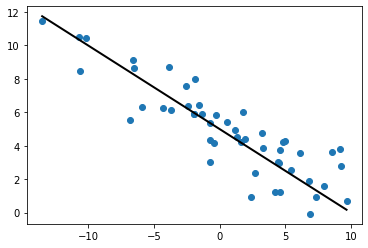

In [ ]:
X=scipy.stats.norm.rvs(0, 5, size=50)
beta0, beta1=5, -.5

def lin_fxn(X, beta0, beta1):
    return X*beta1+beta0
y_true=lin_fxn(X, beta0, beta1)
sd=1.5
err= scipy.stats.norm.rvs(0,sd, size=len(X))

y_obs=y_true+err

pyplot.scatter(X,y_obs, )
domain=numpy.linspace(X.min(),X.max(), 100)
pyplot.plot(domain, lin_fxn(domain, beta0, beta1), c='black', lw=2 )

In [ ]:
# import pymc3 as pm
# with pm.Model

In [ ]:
@Model
class LinearModel(ModelBase):
    def model(self, *args, **kwargs):
        #Define the priors
        beta=self.Normal(name='beta', shape=2, loc=0,scale=10)
        err=self.Gamma(name='err', a=1.5, scale=4)
        
        #Compute the predicted values of Y
        y_pred=X*beta[1]+ beta[0]
        
        #Define the likelihood by creating an RV with a predefined value equal to y_obs
        obs=self.Normal(name='Y_obs', value=y_obs, loc=y_pred, scale=err)

<class 'amppl.distributions.Normal'>
<class 'amppl.distributions.Gamma'>
<class 'amppl.distributions.Normal'>


In [ ]:
opt=Optimizer(model=LinearModel)

<class 'amppl.distributions.Normal'>
<class 'amppl.distributions.Gamma'>
<class 'amppl.distributions.Normal'>


In [ ]:
opt.fit(1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

<class 'amppl.distributions.Normal'>
<class 'amppl.distributions.Gamma'>
<class 'amppl.distributions.Normal'>


 29%|██▊       | 287/1000 [00:01<00:03, 217.45it/s]

converged
<class 'amppl.distributions.Normal'>
<class 'amppl.distributions.Gamma'>
<class 'amppl.distributions.Normal'>


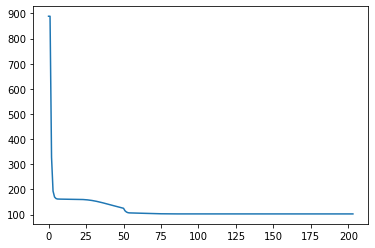

In [ ]:
pyplot.plot(opt.hist)

In [ ]:
opt.parameters

{'beta': DeviceArray([ 4.9023514, -0.5070016], dtype=float32),
 'err': DeviceArray([1.5863639], dtype=float32),
 'Y_obs': DeviceArray([], dtype=float32)}

In [ ]:
ndata=10000
ngroups=100
X=scipy.stats.norm.rvs(0,2.5, size=ndata)
group=numpy.repeat(numpy.arange(ngroups), ndata/ngroups).astype(int)
beta1=scipy.stats.norm.rvs(2,.7, size=ngroups)
beta0=scipy.stats.norm.rvs(-3,1, size=ngroups)
err=scipy.stats.norm.rvs(0,2, size=ndata)
Y=X*beta1[group]+beta0[group]+err
@Model
class HierarchicalModel(ModelBase):

    def model(self, *args, **kwargs):
        
        #define the hyperpriors for the mean coefficient across all groups
        mean_0=self.Normal('mean_0',loc=0, scale=5,label='hyperprior' )
        mean_1=self.Normal('mean_1',loc=0, scale=5,label='hyperprior' )
        
        #define the hyperpriors for the standard deviation of the coefficients across groups
        sd_0=self.Gamma('sd_0',a=1, scale=3,label='hyperprior' )
        sd_1=self.Gamma('sd_1',a=1, scale=3,label='hyperprior')
        
        #define the priors on the regression coefficients for each group
        beta_0=self.Normal('beta_0',shape=ngroups,loc=mean_0, scale=sd_0, label='prior' )
        beta_1=self.Normal('beta_1',shape=ngroups,loc=mean_1, scale=sd_1 , label='prior')
        
#         def noncentered_normal(x, m, s):
#             return x*s+m


#         beta_1=self.TransformedRV('beta_1',value= beta_1_raw, shape=1,
#                                   transformation=noncentered_normal, in_axes=[0,None,None], m=mean_1, s=sd_1)

#         beta_0=self.TransformedRV('beta_0',value= beta_0_raw, shape=1,
#                                   transformation=noncentered_normal, m=mean_0, s=sd_0)
        #define the prior on the residuals
        err=self.Gamma('err',a=1, loc=0, scale=3, label='err_prior')
        
        # compute the model's predictions of Y given the coefficients
        y_pred=beta_0[group]+beta_1[group]*X

        # Evaluate the likelihood of the observed data
        obs=self.Normal('Y', value=Y,loc=y_pred, scale=err, label='likelihood')

<class 'amppl.distributions.Normal'>
<class 'amppl.distributions.Normal'>
<class 'amppl.distributions.Gamma'>
<class 'amppl.distributions.Gamma'>
<class 'amppl.distributions.Normal'>
<class 'amppl.distributions.Normal'>
<class 'amppl.distributions.Gamma'>
<class 'amppl.distributions.Normal'>


In [ ]:
parameter_sets=[{'hyperprior'},
                                                       {'prior'}]

In [ ]:
parameter_labels=HierarchicalModel.rv_labels
for subset in parameter_sets:
    identity_labels=1.*numpy.array([p in subset for p in parameter_labels ] )
    print (identity_labels)

[1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 

In [ ]:
opt=Optimizer(model=HierarchicalModel, parameter_sets=[{'hyperprior'},
                                                       {'prior'},
                                                      {'err_prior'}])

ABCMeta
ABCMeta
ABCMeta
ABCMeta
ABCMeta
ABCMeta
ABCMeta
ABCMeta


In [ ]:
opt.parameter_sets

[{'hyperprior'}, {'prior'}, {'err_prior'}]

In [ ]:
opt.update_rules[2].is_parameter_in_set

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1.])

In [ ]:
opt.fit(10000)

  0%|          | 0/10000 [00:00<?, ?it/s]

ABCMeta
ABCMeta
ABCMeta
ABCMeta
ABCMeta
ABCMeta
ABCMeta
ABCMeta


  3%|▎         | 287/10000 [00:06<03:30, 46.05it/s]


converged
ABCMeta
ABCMeta
ABCMeta
ABCMeta
ABCMeta
ABCMeta
ABCMeta
ABCMeta


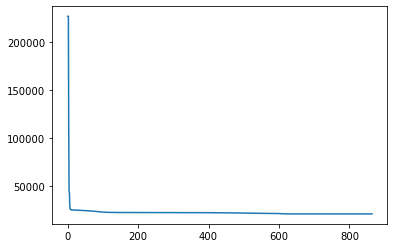

In [ ]:
pyplot.plot(opt.hist)

In [ ]:
opt.parameters

{'mean_0': DeviceArray([-2.9645472], dtype=float32),
 'mean_1': DeviceArray([1.991621], dtype=float32),
 'sd_0': DeviceArray([0.9177139], dtype=float32),
 'sd_1': DeviceArray([0.8984349], dtype=float32),
 'beta_0': DeviceArray([-3.6467054 , -3.4030783 , -3.4131365 , -4.506061  ,
              -1.4360375 , -2.2899787 , -2.1852963 , -3.110926  ,
              -2.739114  , -3.1357718 , -2.5499756 , -3.4678113 ,
              -3.31886   , -3.3939397 , -4.9741683 , -3.5703957 ,
              -1.9760733 , -0.97969854, -4.0140376 , -2.8024843 ,
              -1.5327808 , -2.541287  , -3.2508428 , -4.2108746 ,
              -3.4977052 , -2.8950474 , -2.725612  , -4.8443465 ,
              -3.0765343 , -3.9288433 , -4.4613457 , -2.9772422 ,
              -2.5262942 , -2.0531    , -2.107642  , -2.2224066 ,
              -2.0633898 , -2.0434916 , -2.8297741 , -3.303556  ,
              -4.0077686 , -3.4031422 , -2.1176174 , -2.108094  ,
              -3.812442  , -2.7051742 , -1.4362227 , -3.6976

In [ ]:
len(opt.update_rules[2].stepsize_rule.hist)

289

In [ ]:
# opt.stepsize_rule.hist

In [ ]:
def 
    check_f=armijo_condition(alphas[-1], x_t[-1], proposal, func, g_t[-1],
                         f, .5)
        ### Perform a two-way linesearch to find the largest stepsize satisfying the Armijo condition
        ## for all early iterations and every 50 iterations thereafter. Also, do so if the current proposal fails the Armijo condition
        if i<15 or check_f==False or i%50==0:
            foreward_step, foreward_res=forward_linesearch(alphas[-1], x_t[-1],proposal,func, g_t[-1], hist[-1],.8, .5, max_iter=10)
            backward_step, backward_res=backward_linesearch(alphas[-1], x_t[-1],proposal,func,g_t[-1], hist[-1],.8, .5, max_iter=200)
            if foreward_res==True:
                alphas.append(foreward_step)
            elif backward_res==True:
                alphas.append(backward_step)
            else:
    #             alphas.append(alphas[-1])
                alphas.append(backward_step)

        else:
            alphas.append(alphas[-1])

SyntaxError: invalid syntax (<ipython-input-28-cb1d23f8a730>, line 1)

In [ ]:
def fit_model(model, n_iter=50000):
    hist=[]
    g_t=[]
    x_t=[]
    val_grad=jit(value_and_grad(lambda x: (-jnp.arcsinh(model.set_state_and_evaluate(x)))))
    func=jit(lambda x: (-jnp.arcsinh(model.set_state_and_evaluate(x))))
    x0=model.generate_vector()
    # x0=eCLIP_model.estimate_prior_mean(reps=10)
    # x0=vector
    f,g=val_grad(x0)
    a0=numpy.abs(g).max()
    alphas=[a0]
    proposal_rule=ADAM()
    x_t.append(x0)
    decay=.9
    conv_counter=0
    for i in tqdm(range(n_iter)):
        f,g=val_grad(x_t[-1])
        if numpy.isnan(numpy.sum(f)): 
            print ('Invalid objective value encountered')
            break
        hist.append(f)
        g_t.append(g)
        ### Get the current proposal
        if conv_counter<20:
            proposal=proposal_rule.step_update(g_t[-1], alphas[-1], i+1)
        else:
            proposal=-g_t[-1]
        ### Check whether the current proposal satisfies the Armijo condition
        check_f=armijo_condition(alphas[-1], x_t[-1], proposal, func, g_t[-1],
                         f, .5)
        ### Perform a two-way linesearch to find the largest stepsize satisfying the Armijo condition
        ## for all early iterations and every 50 iterations thereafter. Also, do so if the current proposal fails the Armijo condition
        if i<15 or check_f==False or i%50==0:
            foreward_step, foreward_res=forward_linesearch(alphas[-1], x_t[-1],proposal,func, g_t[-1], hist[-1],.8, .5, max_iter=10)
            backward_step, backward_res=backward_linesearch(alphas[-1], x_t[-1],proposal,func,g_t[-1], hist[-1],.8, .5, max_iter=200)
            if foreward_res==True:
                alphas.append(foreward_step)
            elif backward_res==True:
                alphas.append(backward_step)
            else:
    #             alphas.append(alphas[-1])
                alphas.append(backward_step)

        else:
            alphas.append(alphas[-1])
        ### Update the parameter
        if jnp.max(jnp.abs(alphas[-1]*proposal))>1:
            dampen=1./jnp.max(jnp.abs(alphas[-1]*proposal))
        else:
            dampen=1
        x_t.append(x_t[-1] +alphas[-1]*proposal*dampen )
        ### Make any updates to the proposal rule
        proposal_rule.update_history(g_t[-1], alphas[-1], i+1)

        ### Check for convergence
        if i>5:
            discard=x_t.pop(0)
            discard=g_t.pop(0)
            if hist[-1]==hist[-2]:
                conv_counter+=1
            else:
                conv_counter=0
            if conv_counter>20:
                print ('converged')
                break
    model.set_state_and_evaluate(x_t[-1])
    return model, hist, x_t

model, hist, x_t=fit_model(LinearModel)



In [ ]:
#hide 
from matplotlib import pyplot
import seaborn

In [ ]:
#hide 
from matplotlib import pyplot
import seaborn

In [ ]:
#export
@jit
def adjust_step(step, max_step):
    max_proposal=jnp.max(jnp.abs(step))

    good_step=(jnp.abs(step)<max_step)*1.
    step=step*good_step+(1-good_step)*jnp.sign(step)*max_step 
    return step

In [ ]:
adjust_step(jnp.ones(5),.1)

In [ ]:

class ProposalBase(ABC):
    """A helper class for constructing proposal rules"""
#     @abstractmethod
    #This is the workhorse of the class
    
    

    def evaluate(self,ghat, nu, t=0., optimizer=None):


        step=self.step_update(ghat,
                              nu, 
                              t,)
    
        if self.max_step<jnp.inf:
            #I would prefer these be called during creation
            try:
                self.max_step=float(self.max_step)
                
                assert self.max_step>0
            except:
                AssertionError("max_step must be a number greater than zero")
            
            #If the proposed step is too large, rescale it
    
            step=adjust_step(step, self.max_step)
            
        return step
    
    @abstractmethod
    #This is the workhorse of the class
    def step_update(self): pass
    

In [ ]:

class Standard(UpdateBase):

    """A standard gradient descent update."""
    def __init__(self, max_step=jnp.inf):
        self.max_step=max_step

        pass

    def step_update(self,ghat, nu, t=0. ):
        
        return -nu*ghat

For ADAM, I need to separate the proposal and updating the gradient histories

In [ ]:

class ADAM(UpdateBase):
    def __init__(self,b1=.9, b2=.999, eps=1e-8, max_step=jnp.inf):
        self.max_step=max_step
        self.beta1=b1
        self.beta2=b2
        self.eps=eps
        
        self.m_t=0.
        self.v_t=0.
    def step_update(self,ghat, nu, t ):
        #Update the gradient histories
#         print (ghat)

        self.m_t=self.beta1*self.m_t+(1.-self.beta1)*ghat
        self.v_t=self.beta2*self.v_t+(1.-self.beta2)*ghat**2
#         print (self.m_t)
#         print (self.v_t)
        
        #compute the bias corrections
        m_hat=self.m_t/(1.-self.beta1**(t))
        v_hat=self.v_t/(1.-self.beta2**(t))
        
        #compute the proposed step
        return -nu*m_hat/(v_hat**.5+self.eps)

In [ ]:

# class GradientDescent():
#     def __init__(self, model,x_0=None, step_size=.1, method='adam', objective_transform=None,step_tune=.9,record_interval=None,
#                  opt_kwargs={},
#                 *args,
#                 **kwargs):
#         self.model=model
#         self.step_tune=step_tune
#         print ('new')
#         if isinstance(x_0, type(None)):
#             self.x_0=self.model.generate_vector()
#         else:
#             self.x_0=x_0
#         self.x_t=self.x_0
#         self.xt_m1=self.x_0
#         self.parameters=self.model.vector2values(self.x_t)
        
#         self.step_size=step_size
#         self.record_interval=record_interval
#         self.method=method
#         self.objective_transform=objective_transform
        
#         self.update_rule=ADAM( **opt_kwargs)
        
#         self.x_list=[self.x_t]
#         self.p_list=[]
#         self.args=args
#         self.kwargs=kwargs
#         self.value_t_m1=jnp.inf
        
#         if isinstance(objective_transform, type(None)):
#             def loss_func(val):
#                 return -1*self.model.set_state_and_evaluate(val, *self.args, **self.kwargs)
#         else:
#             def loss_func(val):
#                 return -1*objective_transform(self.model.set_state_and_evaluate(val, *self.args, **self.kwargs))
#         self.val_grad=value_and_grad(jit(loss_func))
#         self.ValGrad=ValueWithGrad(self.val_grad)
        
#         self.hist=[]
#         self.t=0
#         self.no_steps_in_a_row=0
#     def step(self):
#         self.t+=1
#         value, grads = self.val_grad(self.x_t)
        
#         if value<=self.value_t_m1:
#             self.hist.append(value)

# #             self.no_steps_in_a_row=0
#             proposed_update= #self.update_rule.evaluate(grads, self.step_size, self.t)
#         else:
#             value, grads = self.val_grad(self.xt_m1)
#             self.xt=self.xt_m1
#             proposed_update= self.update_rule.evaluate(grads, self.step_size, self.t)
# #             alpha=linesearch.line_search(self.ValGrad.get_value, self.ValGrad.get_grad, self.xt_m1, proposed_update)
#             alpha=linesearch.line_search_armijo(val_grad.get_value, self.xt_m1,proposed_update,gfk=grads, old_fval=value)
# #             print (alpha)
# #             print (jabber)
#             print (alpha)
            
#             if alpha[0]==None:
#                 self.step_size=self.step_size/2
#             else:
#                 self.step_size=alpha[0]
#             proposed_update= self.update_rule.evaluate(grads, self.step_size, self.t)
# #             proposed_update=alpha[-1]
#         self.value_t_m1=value
#         self.xt_m1=self.x_t
# #             value, grads = self.val_grad(self.x_t)
# # #             self.step_size*=self.step_tune
# #             self.no_steps_in_a_row+=1.
# #             proposed_update= (self.x_t-self.xt_m1)*(2**(-self.no_steps_in_a_row))
# # #             print (proposed_update) 
# #         self.x_t=self.xt_m1
# # #         print (self.x_t)
# # #         print (proposed_update)
#         self.x_t=self.x_t+proposed_update
        
# #         self.opt_state[0]=(new_opt_state, proposed_update.packed_state[0][1],proposed_update.packed_state[0][2])
#         self.hist.append(value)

#         if isinstance(self.record_interval, type(None))==False:
#             if self.t%self.record_interval==0:
#                 self.x_list.append(self.x_t)
#                 self.p_list.append(proposed_update)
    
#     def fit(self,niter=1000):
#         for i in tqdm(range(niter)):
#             self.step()
#             if self.no_steps_in_a_row>100: break
# #             self.x_t=self.opt_state.packed_state[0][0]
#         self.finalize()
#         self.parameters=self.model.vector2values(self.x_t)
#     def finalize(self):
        
#         self.model.set_state_and_evaluate(self.x_t)

In [ ]:
# class GradientDescent():
#     def __init__(self, model,x_0=None, step_size=.1, method='adam',update_schedule=[], objective_transform=None,step_tune=.9,record_interval=None,
#                  opt_kwargs={},
#                 *args,
#                 **kwargs):
#         self.model=model
#         self.step_tune=step_tune
#         print ('new')
#         if isinstance(x_0, type(None)):
#             self.x_0=self.model.generate_vector()
#         else:
#             self.x_0=x_0
#         self.x_t=self.x_0
#         self.xt_m1=self.x_0
#         self.parameters=self.model.vector2values(self.x_t)
        
#         self.step_size=step_size
#         self.record_interval=record_interval
#         self.method=method
#         self.objective_transform=objective_transform
        
        
        
#         self.x_list=[self.x_t]
#         self.p_list=[]
#         self.args=args
#         self.kwargs=kwargs
#         self.value_t_m1=jnp.inf
#         self.update_schedule=update_schedule
#         self.update_cycle=len(self.update_schedule)
#         self.update_rule=[ADAM( **opt_kwargs) for i in range(self.update_cycle)]
#         self.schedule_ind=[]
#         if self.update_schedule!=[]:
#             for param_set in self.update_schedule:
#                 self.schedule_ind.append(numpy.zeros(len(self.x_0)))
                
#                 for param in param_set:
# #                     print (numpy.array(self.model.vector_labels)==param)
#                     self.schedule_ind[-1]+=numpy.array(self.model.vector_labels)==param
#                 self.schedule_ind[-1]=1*(self.schedule_ind[-1]!=0)
        
#         if isinstance(objective_transform, type(None)):
#             def loss_func(val):
#                 return -1*self.model.set_state_and_evaluate(val, *self.args, **self.kwargs)
#         else:
#             def loss_func(val):
#                 return -1*objective_transform(self.model.set_state_and_evaluate(val, *self.args, **self.kwargs))
#         self.val_grad=value_and_grad(jit(loss_func))
#         self.ValGrad=ValueWithGrad(self.val_grad)
        
#         self.hist=[]
#         self.t=0
#         self.no_steps_in_a_row=0
#     def step(self):

#         value, grads = self.val_grad(self.x_t)
#         sched_ind=(self.t)%self.update_cycle
#         self.t+=1
# #         print (self.t, sched_ind)
#         update_ind=self.schedule_ind[sched_ind]==1
#         proposed_update= self.update_rule[sched_ind].evaluate(grads[update_ind], self.step_size, self.t-sched_ind)
#         x_t=numpy.array(self.x_t)
#         x_t[update_ind]=x_t[update_ind]+ proposed_update  
#         self.x_t=jnp.array(x_t)
# #         self.opt_state[0]=(new_opt_state, proposed_update.packed_state[0][1],proposed_update.packed_state[0][2])
#         self.hist.append(value)

#         if isinstance(self.record_interval, type(None))==False:
#             if self.t%self.record_interval==0:
#                 self.x_list.append(self.x_t)
#                 self.p_list.append(proposed_update)
    
#     def fit(self,niter=1000):
#         for i in tqdm(range(niter)):
#             self.step()
#             if self.no_steps_in_a_row>100: break
# #             self.x_t=self.opt_state.packed_state[0][0]
#         self.finalize()
#         self.parameters=self.model.vector2values(self.x_t)
#     def finalize(self):
        
#         self.model.set_state_and_evaluate(self.x_t)

In [ ]:
opt=GradientDescent(LinearModel,step_size=.1,record_interval=10)

In [ ]:
opt.fit(500,)

100%|██████████| 500/500 [00:07<00:00, 67.32it/s]


In [ ]:
opt.parameters


{'beta': DeviceArray([ 4.9516187, -0.5399864], dtype=float32),
 'err': DeviceArray([1.5140594], dtype=float32),
 'Y_obs': DeviceArray([], dtype=float32)}

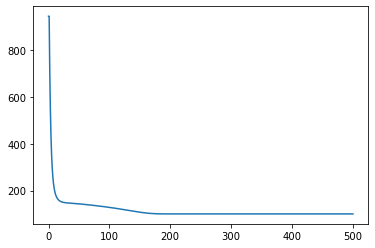

In [ ]:
pyplot.plot(opt.hist)

In [ ]:
LinearModel.parameters

{'beta': DeviceArray([ 4.9516187, -0.5399864], dtype=float32),
 'err': DeviceArray([1.5140594], dtype=float32),
 'Y_obs': DeviceArray([0.], dtype=float32)}

In [ ]:
opt.x_t

In [ ]:
unpacked.subtree[0]=jnp.ones(3)

In [ ]:
ndata=10000
ngroups=1000
X=scipy.stats.norm.rvs(0,2.5, size=ndata)
group=numpy.repeat(numpy.arange(ngroups), ndata/ngroups).astype(int)
beta1=scipy.stats.norm.rvs(2,.7, size=ngroups)
beta0=scipy.stats.norm.rvs(-3,1, size=ngroups)
err=scipy.stats.norm.rvs(0,2, size=ndata)
Y=X*beta1[group]+beta0[group]+err
@Model
class LinearModel(ModelBase):

    def model(self, *args, **kwargs):
        
        #define the hyperpriors for the mean coefficient across all groups
        mean_0=self.Normal('mean_0',loc=0, scale=5 )
        mean_1=self.Normal('mean_1',loc=0, scale=5 )
        
        #define the hyperpriors for the standard deviation of the coefficients across groups
        sd_0=self.Gamma('sd_0',a=1, scale=3 )
        sd_1=self.Gamma('sd_1',a=1, scale=3)
        
        #define the priors on the regression coefficients for each group
        beta_0=self.Normal('beta_0',shape=ngroups,loc=mean_0, scale=sd_0 )
        beta_1=self.Normal('beta_1',shape=ngroups,loc=mean_1, scale=sd_1 )
        
#         def noncentered_normal(x, m, s):
#             return x*s+m


#         beta_1=self.TransformedRV('beta_1',value= beta_1_raw, shape=1,
#                                   transformation=noncentered_normal, in_axes=[0,None,None], m=mean_1, s=sd_1)

#         beta_0=self.TransformedRV('beta_0',value= beta_0_raw, shape=1,
#                                   transformation=noncentered_normal, m=mean_0, s=sd_0)
        #define the prior on the residuals
        err=self.Gamma('err',a=1, loc=0, scale=3)
        
        # compute the model's predictions of Y given the coefficients
        y_pred=beta_0[group]+beta_1[group]*X

        # Evaluate the likelihood of the observed data
        obs=self.Normal('Y', value=Y,loc=y_pred, scale=err)

In [ ]:
import scipy.optimize.linesearch as linesearch

In [ ]:
class ValueWithGrad():
    def __init__(self, val_and_grad, theta=jnp.inf):
        self.val_and_grad=val_and_grad
        self.theta=theta
        self.value=None
        self.grad=None
    
    def evaluate(self):
        self.value,self.grad=self.val_and_grad(self.theta)
        
    def get_value(self, theta):
        if numpy.array_equal( theta,self.theta)==False:
            self.theta=theta
            self.evaluate()
        return self.value
    
    def get_grad(self, theta):
        if numpy.array_equal( theta,self.theta)==False:
            self.theta=theta
            self.evaluate()
        return self.grad

In [ ]:
loss_func=lambda val:-1*LinearModel.set_state_and_evaluate(val)
val_grad=ValueWithGrad(value_and_grad(jit(loss_func)))

In [ ]:
theta=LinearModel.generate_vector()

In [ ]:
val_grad.get_value(theta)

In [ ]:
p0=val_grad.get_grad(theta)

In [ ]:
p0

In [ ]:
for i  in tqdm(range(100)):
    alpha=linesearch.line_search(val_grad.get_value, val_grad.get_grad, theta, p0*-1)

In [ ]:
for i  in tqdm(range(100)):
    alpha=linesearch.line_search_armijo(val_grad.get_value, theta, p0*-1,gfk=val_grad.get_grad(theta), old_fval=val_grad.get_value(theta))

In [ ]:
alpha

In [ ]:
len(alpha[-1])

In [ ]:
thetas=[theta]
grads=[p0]
s=[numpy.zeros(len(theta))]
q=[numpy.zeros(len(theta))]
for i in range(10):
    new_grad=val_grad.get_grad(thetas[-1])
    new_theta=thetas[-1]-new_grad*alpha[0]
    s.append(new_theta-thetas[-1])
    q.append(new_grad-grads[-1])
    grads.append(new_grad)
    thetas.append(new_theta)
    
thetas=numpy.array(thetas)
grads=numpy.array(grads)
s=numpy.array(s)
q=numpy.array(q)

In [ ]:
import scipy.optimize as scopt
H=scopt.LbfgsInvHessProduct(s[1:,:],q[1:,:])

In [ ]:
H*alpha[0]

In [ ]:
opt=GradientDescent(LinearModel,step_size=.1,record_interval=1,)

In [ ]:
import jax.scipy.optimize as jaxopt

In [ ]:
pyplot.plot(numpy.log(opt.hist))

In [ ]:
theta_hist=numpy.array(opt.x_list)


In [ ]:
pyplot.plot((theta_hist[:,0]))

In [ ]:
opt.finalize()


In [ ]:
pyplot.scatter(beta0, LinearModel.parameters['beta_0'], s=1)

## Scraps

In [ ]:


class Optimizer():
    def __init__(self, model=None,
                 objective_function=None,
                 x_0=None, 
                 proposal_rule=None,
                 stepsize_rule=None,
                 max_step_rule=None,
                 convergence_condition=None,
                 tracker=None,
                 objective_transform=None,
                 parameter_sets=[],
                 opt_kwargs={},val_and_grad=None,
                *args,
                **kwargs):
        
        """An optimizer couples three things
            1. An objective function
            2. An proposal rule
            3. An update routine
            
        ****
        **Arguments:**
        
        `model` (`ammpl` model): The amppl model to optimize. If not provided, an `objective_function` may be \
        passed instead
        
        `objective_function` (callable): If not provided, an amppl ModelBase class may be passed instead 
        
        `x_0` (numpy.array): The initial guess. If x_0=None and a `model` is provided, this will generated \
        with `model.generate_vector()`. If an `objective_function` is provided, `x_0` must be specified by \
        the user (the `Optimizer` has no way to guess how long `x_0` should be)
        
        `proposal_rule` (A proposal rule from `amppl.opt.proposals`):
        
        `stepsize_rule`=None,
        
        `max_step_rule`=None,
        
        `convergence_condition`=None,
        
        `tracker`=None,
        
        `objective_transform`=None,
        
        `parameter_sets`=[],
        
        `opt_kwargs`={},
        
        `val_and_grad`=None,
        
        *args, **kwargs
        
        """
        if isinstance(proposal_rule, type(None)):
            proposal_rule=ADAM()
        if isinstance(stepsize_rule, type(None)):
            stepsize_rule=LineSearchStepsize()
        if isinstance(max_step_rule, type(None)):
            max_step_rule=ScaleDownStepsize(1)
        if isinstance(convergence_condition, type(None)):
            convergence_condition=ConvergeWhenPlateau(n_iter=20)
            
        self.model=model
        if isinstance(self.model, type(None))==False:
            if model.compute_value_and_grad==True:
                self.val_grad=model.value_and_grad
        assert ((isinstance(self.model, type(None))==True)*
                (isinstance(val_and_grad, type(None))==True))!=1, "Either a model or a function that returns the loss \
                and gradient must be provided."
        self.proposal_rule=proposal_rule
        self.stepsize_rule=stepsize_rule
        self.max_step_rule=max_step_rule
        self.convergence_condition=convergence_condition.evaluate
        
        #If an initial guess isn't specified, generate one from the model
        if isinstance(x_0, type(None)):
            self.x_0=self.model.generate_vector()
        else:
            self.x_0=x_0
            
        self.x_t=copy(self.x_0)
        if isinstance(self.model, type(None))==False:
            self.parameters=self.model.vector2values(self.x_t)
        
        self.objective_transform=objective_transform
        
        
        
        self.args=args
        self.kwargs=kwargs
        self.tracker=[]

        if isinstance(val_and_grad, type(None)):
            if isinstance(objective_transform, type(None)):
                def loss_func(val, random_state=None):
                    return -1*self.model.set_state_and_evaluate(val,random_state=random_state)
            else:
                def loss_func(val,random_state=None):
                    return -1*objective_transform(self.model.set_state_and_evaluate(val,random_state=random_state))
            self.val_grad=value_and_grad(jit(loss_func))
        else:
            self.val_grad=val_and_grad
        self.value_and_grad=ValueWithGrad(self.val_grad)
#         value, grads = self.val_grad(self.get_params(self.opt_state))

#         value, grads = self.val_grad(self.get_params(self.opt_state), random_state=None)
        value, grads=self.value_and_grad.get_value_and_grad(x_0)

        self.hist=[value]
        self.t=0
        self.best_val=self.hist[-1]
        self.best_x=self.x_t

        
    def step_for_parameter_subset(self,
                                  proposal_rule,
                                  stepsize_rule,
                                  max_step_rule,
                                  subset_labels=None):
        f_t,g_t=self.value_and_grad.get_value_and_grad(self.x_t)
        
        #If no subset labels are provided, make a proposal for all parameters
        if isinstance(subset_labels, type(None)):
            proposed_step=proposal_rule.step_update(g_t, self.t+1)
        #Otherwise, only make a proposal for the specified parameters
        else:
            proposed_step=subset_labels*proposal_rule.step_update(g_t, self.t+1)
            
        stepsize, result=stepsize_rule.evaluate(x=self.x_t,
                                             proposal=proposed_step,
                                             t=self.t+1,
                                             func=self.value_and_grad.get_value,
                                             grad=self.value_and_grad.get_grad,
                                             func_x=f_t,
                                             grad_x=g_t,)
#         print (result)
        
        proposal=max_step_rule.evaluate(stepsize*proposed_step)
        self.x_t=self.x_t +proposal
        self.hist.append(f_t)
        proposal_rule.update_history(g_t, self.t+1)
        
    def step(self):
        f_t,g_t=self.value_and_grad.get_value_and_grad(self.x_t)
        proposed_step=self.proposal_rule.step_update(g_t, self.t+1)
        stepsize, result=self.stepsize_rule.evaluate(x=self.x_t,
                                             proposal=proposed_step,
                                             t=self.t+1,
                                             func=self.value_and_grad.get_value,
                                             grad=self.value_and_grad.get_grad,
                                             func_x=f_t,
                                             grad_x=g_t,)
#         print (result)
        
        proposal=self.max_step_rule.evaluate(stepsize*proposed_step)
        self.x_t=self.x_t +proposal
        self.hist.append(f_t)
        self.proposal_rule.update_history(g_t, self.t+1)
        self.t+=1
        
        
    def fit(self,niter=1000):
        for i in tqdm(range(niter)):
            self.step()
            conv_test=self.convergence_condition(self.hist)
            if conv_test==True:
                break
            
        self.finalize()
        if isinstance(self.model, type(None))==False:
            self.parameters=self.model.vector2values(self.x_t)
    def finalize(self):
        if isinstance(self.model, type(None))==False:
            self.model.set_state_and_evaluate(self.x_t)
#         if self.model.stochastic==False:
#             value, grads = self.val_grad(self.get_params(self.opt_state), random_state=None)
#         else:

#             value, grads = self.val_grad(self.get_params(self.opt_state),random_state=self.model.z)

            